In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import importlib
import scripts.preprocessing as preprocessing
importlib.reload(preprocessing)
import torch
import torchvision
from torchvision import transforms
import torchsummary
import torch.optim as optim
import scripts.models as models
from utils import *

In [3]:
# check if CUDA is available
device = use_GPU()

CUDA is available!  Training on GPU ...
cuda:0


In [9]:
# Load data
folder_structure = preprocessing.create_dataset()

Populating data/train
Populating data/test


In [10]:
# transform it in a dataframe
a = pd.DataFrame([(k, len(v)) for k,v in folder_structure[0].items()], columns=['class', 'count'])
b = pd.DataFrame([(k, len(v)) for k,v in folder_structure[1].items()], columns=['class', 'count'])
image_counts = pd.merge(a, b, on='class', how='outer', suffixes=('_train', '_test'))

In [11]:
image_counts

,class,count_train,count_test
0,adobo,498,43
1,ambrosia_food,569,35
2,apple_pie,549,41
3,apple_turnover,504,43
4,applesauce,484,39
...,...,...,...
246,vol_au_vent,447,57
247,waffle,376,44
248,welsh_rarebit,319,41
249,wonton,513,48


In [13]:
image_counts.loc[np.argmin(image_counts['count_train']),:]

class          marble_cake
count_train             34
count_test              49
Name: 143, dtype: object

In [14]:
preprocessing.create_validation(42);

In [64]:
transform = transforms.Compose([
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize pixel values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Resize images to a common size
    transforms.Resize(size=(224,224)) 
])

# Load the training dataset
trainset = torchvision.datasets.ImageFolder(root='data/train', transform=transform)

# Create data loader for training data with batch size 4 and shuffling
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

valset = torchvision.datasets.ImageFolder(root='data/val', transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root='data/test', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

In [65]:
model = models.SqueezeNet()
model.to(device);

In [66]:
torchsummary.summary(model, (3, 256, 256));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 127, 127]           1,792
              ReLU-2         [-1, 64, 127, 127]               0
         MaxPool2d-3           [-1, 64, 63, 63]               0
            Conv2d-4           [-1, 16, 63, 63]           1,040
              ReLU-5           [-1, 16, 63, 63]               0
            Conv2d-6           [-1, 64, 63, 63]           1,088
              ReLU-7           [-1, 64, 63, 63]               0
            Conv2d-8           [-1, 64, 63, 63]           9,280
              ReLU-9           [-1, 64, 63, 63]               0
             Fire-10          [-1, 128, 63, 63]               0
           Conv2d-11           [-1, 16, 63, 63]           2,064
             ReLU-12           [-1, 16, 63, 63]               0
           Conv2d-13           [-1, 64, 63, 63]           1,088
             ReLU-14           [-1, 64,

In [68]:
## train the model
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
patience = 3


In [69]:
train_loss=[] # store the training loss

best_val_loss = np.inf # initialize the best validation loss to infinity for patience
patience_counter = 0 # initialize the counter for patience

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0

    for i, data in enumerate(trainloader):
        # Get the inputs
        inputs, labels = data
        # Move the inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # clear the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Add the loss to the training set's running loss
        running_loss += loss.item()
        epoch_loss += loss.item()
        # we  keep the variable separated because we want to print the running loss 
        #every 2000 mini-batches and len(trainloader)%2000 is not 0

        # Print the loss every 2000 mini-batches
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
    # Add the epoch loss to the training loss list
    train_loss.append(epoch_loss/len(trainloader))
    if(epoch_loss/len(trainloader) < best_val_loss):
        best_val_loss = epoch_loss/len(trainloader)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > patience:
            print("Early stopping at epoch ", epoch)
            break
        
    # Step the scheduler  
    scheduler.step()

[1,  2000] loss: 5.526
[1,  4000] loss: 5.525
[1,  6000] loss: 5.525
[1,  8000] loss: 5.525
[1, 10000] loss: 5.525
[2,  2000] loss: 5.525
[2,  4000] loss: 5.525


KeyboardInterrupt: 

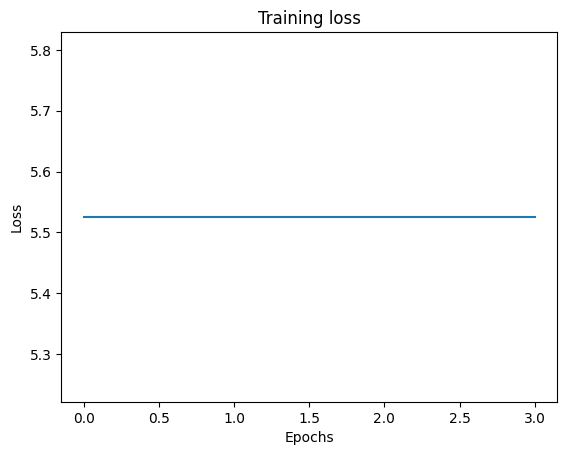

In [ ]:
# plot the training loss
plt.plot(train_loss[1:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()


In [74]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class EfficientCNN(nn.Module):
    def __init__(self, num_classes=251):
        super(EfficientCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        # Batch Normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Fully connected layers
        self.fc1 = nn.Linear(12544 , 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Convolutional layers with ReLU and MaxPooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 4)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [75]:
model = EfficientCNN()
model.to(device);

In [77]:
# Print model summary
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 64, 112, 112]          18,496
       BatchNorm2d-4         [-1, 64, 112, 112]             128
            Conv2d-5          [-1, 128, 56, 56]          73,856
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7          [-1, 256, 28, 28]         295,168
       BatchNorm2d-8          [-1, 256, 28, 28]             512
            Linear-9                  [-1, 512]       6,423,040
           Linear-10                  [-1, 251]         128,763
Total params: 6,941,179
Trainable params: 6,941,179
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 45.94
Params size (MB): 26.48
Estim

In [78]:
## train the model
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
patience = 5


In [79]:
train_loss=[] # store the training loss

best_val_loss = np.inf # initialize the best validation loss to infinity for patience
patience_counter = 0 # initialize the counter for patience

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0

    for i, data in enumerate(trainloader):
        # Get the inputs
        inputs, labels = data
        # Move the inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # clear the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Add the loss to the training set's running loss
        running_loss += loss.item()
        epoch_loss += loss.item()
        # we  keep the variable separated because we want to print the running loss 
        #every 2000 mini-batches and len(trainloader)%2000 is not 0

        # Print the loss every 2000 mini-batches
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
    # Add the epoch loss to the training loss list
    train_loss.append(epoch_loss/len(trainloader))
    if(epoch_loss/len(trainloader) < best_val_loss):
        best_val_loss = epoch_loss/len(trainloader)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > patience:
            print("Early stopping at epoch ", epoch)
            break
    # Step the scheduler  
    scheduler.step()

[1,  2000] loss: 6.341
[1,  4000] loss: 5.523
[1,  6000] loss: 5.523
[1,  8000] loss: 5.528
[1, 10000] loss: 5.524
[2,  2000] loss: 5.517
[2,  4000] loss: 5.513
[2,  6000] loss: 5.514
[2,  8000] loss: 5.509
[2, 10000] loss: 5.513
[3,  2000] loss: 5.510
[3,  4000] loss: 5.511
[3,  6000] loss: 5.510
[3,  8000] loss: 5.509
[3, 10000] loss: 5.508
[4,  2000] loss: 5.510
[4,  4000] loss: 5.507
[4,  6000] loss: 5.508
[4,  8000] loss: 5.511
[4, 10000] loss: 5.507
[5,  2000] loss: 5.509
[5,  4000] loss: 5.510


KeyboardInterrupt: 

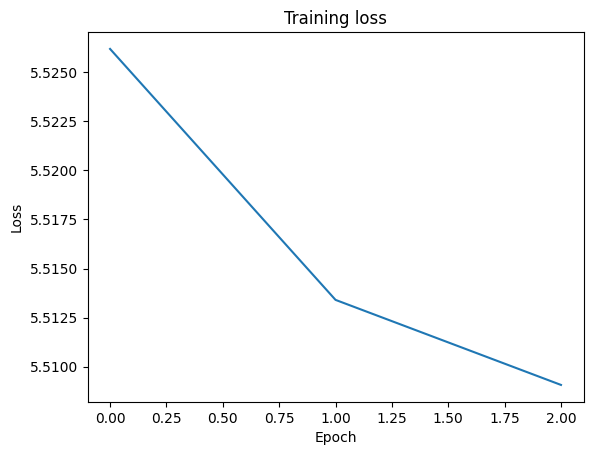

In [63]:
#plot the training loss
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()
